## 분류 실습 : 캐글 신용카드 사기 검출

Kaggle의 신용카드 데이터 세트를 이용해 신용카드 사기 검출 분류 실습  
데이터 다운로드 : www.kaggle.com 에서 검색  
credit card fraud


**신용카드 데이터 세트 특징**
- 2013년 European Card 사용 트랜잭션을 가공해서 생성
- 불균형(Imbalanced)되어 있는 데이터 셋 284,807건의 데이터 중 492건이 Fraud(사기)

    - 레이블인 Class 속성이 매우 불균형한 분포
        - 0 값 : 정상 트랜잭선
        - 1 값 : 사기 트랜잭션 (0.172 %)


**Tip. 일반적인 사기 검출(Fraud Detection)이나 이상 검출(Anomaly Detection) 같은 데이터 세트는 레이블 값이 극도로 불균형한 분포를 이룸**  
- 사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매우 적기 때문


## Credit Card Fraud Detection ML 모델 구축
- 다양한 Feature Engineering 방식을 
- Logistic Regression과 LightGBM 방식을 이용하여 
- 각 방식에 적용 후 평가 비교


**Feature Engineering 주요 작업**
- 주요 Feature의 데이터 분포도 변경
    - Log 변환
- 이상치(Outlier) 제거
- SMOTE 오버 샘플링


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

#그래프 패키지 
import matplotlib.pyplot as plt 
%matplotlib inline 
# 한글 문제 해결
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')# 한글 문제 해결
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')


# 동시 출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./data/creditcard.csv')
card_df.head(3)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


**creditcard 피처 정보**
- Time : 데이터 생성 관련한 속성으로 분석에 큰 의미가 없음 => 삭제
- Amount : 신용카드 트랜잭션 금액
- Class : 레이블, 0-정상, 1-사기

- v1~v28 속성 : 피처 이름이 전혀 들어가 있지 않음
    * kaggle에서 칼럼 확인해보면
        - 민감한 정보를 보호하기 위해서 PCA로 압축한 속성
        
- Amount : 카드 사용액
- Class : 0은 정상 사용, 1은 부정 카드 사용


In [3]:
card_df.shape

(284807, 31)

In [4]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 전처리 함수 :
1. 원본 유지하고 복사본을 반환
    - Time 컬럼은 삭제하고 반환

### 전처리 함수 ① : get_preprocessed_df() 작성

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
def get_preprocessed_df(df=None):
    
    df_copy = df.copy() # 원본 유지
    df_copy.drop('Time', axis=1, inplace=True)
    
    return df_copy

In [7]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1] # 피처 : 마지막 칼럼 전까지
    y_target = df_copy.iloc[:, -1] # 레이블 : 마지막 칼럼
    
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    # stratify: 타겟 값의 분포도에 맞춰, 학습과 테스트 맞춰서 분할 (레이)
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test


#### 데이터 세트 구성

In [9]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [10]:
## 학습 데이터와 테스트 데이터 레이블 분포 확인 
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)


학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


#### 예측 평가 수행 함수 (앞에서 생성)

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

#### LogisticRegression 알고리즘 학습/예측/평가

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test,lr_pred,lr_pred_proba)

LogisticRegression()

오차 행렬
[[85281    14]
 [   61    87]]
정확도: 0.9991, 정밀도: 0.8614, 재현율: 0.5878,    F1: 0.6988, AUC:0.9594


#### 결과
- 재현율이 낮게 나왔음
    - imbalance한 데이터다 보니까 재현율 부분을 중요하게 생각하면 될 것 같음
    - 재현율이 낮아서 예측 모델로서 탐탁치 않음


**앞으로 피처 엔지니어링을 수행할 때마다 모델을 학습/예측/평가하므로 이를 위한 함수 생성**    


**`get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None)`**


In [15]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba) ## 평가진행 함수 호출

**LightGBM 학습/예측/평가.**

- (boost_from_average가 True일 경우 레이블 값이 극도로 불균형 분포를 이루는 경우 재현률 및 ROC-AUC 성능이 매우 저하됨.)  
   - LightGBM 2.1.0 이상 버전에서 이와 같은 현상 발생 
        - 디펄트가 True로 바뀜 (이전에는 False 였음)
   - True일 경우 전반적으로는 좋지만 
        - 레이블 값이 극도로 불균형 분포를 이루는 경우 재현률 및 ROC-AUC 성능이 매우 저하됨


In [16]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


### 결과
1. LogisticRegression 보다 재현율이 많이 향상됨
    - 재현율을 더 향상시킬 수있는 요소를 확인

### 중요 데이터 분포도 변환후 모델 학습/예측/평가

**중요 feature의 분포도 확인**

- **가장 중요한 속성**은 무엇일까?
    * 여러 가지 있을 수 있는데 가장 중요한 것 중 하나는 **Amount**  
        - Amount 아무래도 금액이니까 카드 금액에 따라서 실제 타겟 값에서 사기냐 정상이냐 판단하는데 가장 중요한 피처임


<Figure size 576x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x14d2268e850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<AxesSubplot:xlabel='Amount', ylabel='Density'>

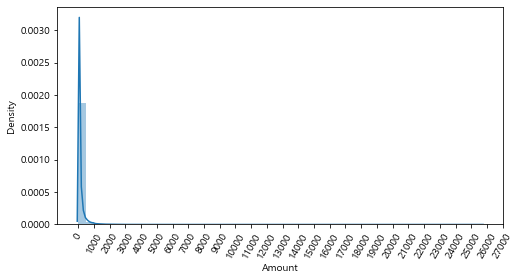

In [17]:
# 중요 속성을 Amount 선정해서 분포도 확인

import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60) # 0에서 3만까지 간격은 1000
sns.distplot(card_df['Amount'])

### 그래프 해석
- 잘 보면 대부분의 금액이 500 유로 미만인데
    - 나머지 작은 값들이 존재 25600까지 
    - 불균형하게 가지고 있음
    - 작은 값들이 길게 오른쪽으로 긴 꼬리를 가지고 있는 구조


### 전처리 함수 ② get_preprocessed_df() 수정
- StandardScaler를 이용하여 Amount 피처 변환 추가


In [18]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None) :
    df_copy = df.copy() #원본 유지
    #표준 스케일링 변환
    scaler =  StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    
    # 변환된 amount를 새로운 컬럼을 추가
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    
    # 기존 Amount 컬럼 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy


**StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가**


In [19]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


**앞의 결과와 비교해서 거의 동일**
- 정규분포 변화하기 전과 별 차이가 없음